# Parameter choice

This notebook demonstrates how the function parameterBounds_MaxCut handles symmetries in gamma and beta to select appropriate bounds.

First do some imports and define handy plotting functions.

In [1]:
from qiskit import *
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *
from qiskit.providers.aer.noise import NoiseModel
from qaoa import *
from pylab import cm

from matplotlib import rc,patches
from scipy import optimize as opt

SAMPLING_E_ATOL = 5e-2
SAMPLING_E_RTOL = 1e-2
SAMPLING_DELTA_V_RTOL = 1e-1
MIN_SAMPLES = 256
MAX_SAMPLES = 32768*2*2
SAMPLING_CONF_IDX = 1

LANDSCAPE_NYQ_FREQ = 32

CIRCUIT_VERSION = 1
CIRCUIT_DEPTH = 1

font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

backend_sim = Aer.get_backend('qasm_simulator')

In [2]:
def sample_landscape(G,gammas,betas,landscape_n_gamma,landscape_n_beta):
    E_landscape = np.zeros((landscape_n_beta,landscape_n_gamma))
    v_landscape = np.zeros((landscape_n_beta,landscape_n_gamma))
    circuits=[]
    for i in range(landscape_n_beta):
        for j in range(landscape_n_gamma):
            beta = betas[i]
            gamma = gammas[j]
            circuit = createCircuit_MaxCut(np.array((gamma,beta)),G,CIRCUIT_DEPTH,CIRCUIT_VERSION)
            [E_list,v_list,_] = sampleUntilPrecision_MaxCut(circuit,G,backend_sim,None,MIN_SAMPLES,
                                                                 MAX_SAMPLES,SAMPLING_E_ATOL,SAMPLING_E_RTOL,
                                                                 SAMPLING_DELTA_V_RTOL,SAMPLING_CONF_IDX)
            E_landscape[i,j] = E_list[-1]
            v_landscape[i,j] = v_list[-1]
            print('%.2f%%' % ((i*landscape_n_gamma+j)*100/(landscape_n_gamma*landscape_n_beta)),end='\r')
    
    return E_landscape,v_landscape

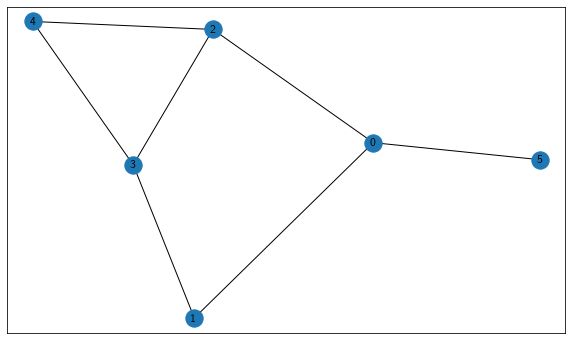

In [3]:
V = np.arange(0,6,1)
E =[(0,1,1),(0,2,2),(2,3,5),(3,1,7),(3,4,3),(4,2,1),(0,5,2)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

pos = nx.spring_layout(G)
pl.figure(figsize=(10,6))
nx.draw_networkx(G,apos=pos)

In [11]:
(gamma_min,gamma_max),(beta_min,beta_max) = parameterBounds_MaxCut(G,decimals=0)

max_weight = max([w for _,_,w in G.edges.data('weight',default=1)])
landscape_n_gamma = int(LANDSCAPE_NYQ_FREQ*np.ceil(gamma_max*(max_weight/2)/(2*np.pi)))
landscape_n_beta = int(LANDSCAPE_NYQ_FREQ*np.ceil(beta_max/(2*np.pi)))

print('landscape_n_gamma: %d' % landscape_n_gamma)
print('landscape_n_beta: %d' % landscape_n_beta)

gammas_landscape = np.linspace(gamma_min,gamma_max,landscape_n_gamma)
betas_landscape = np.linspace(beta_min,beta_max,landscape_n_beta)

E_landscape,v_landscape = sample_landscape(G,gammas_landscape,betas_landscape,landscape_n_gamma,landscape_n_beta)

landscape_n_gamma: 64
landscape_n_beta: 32


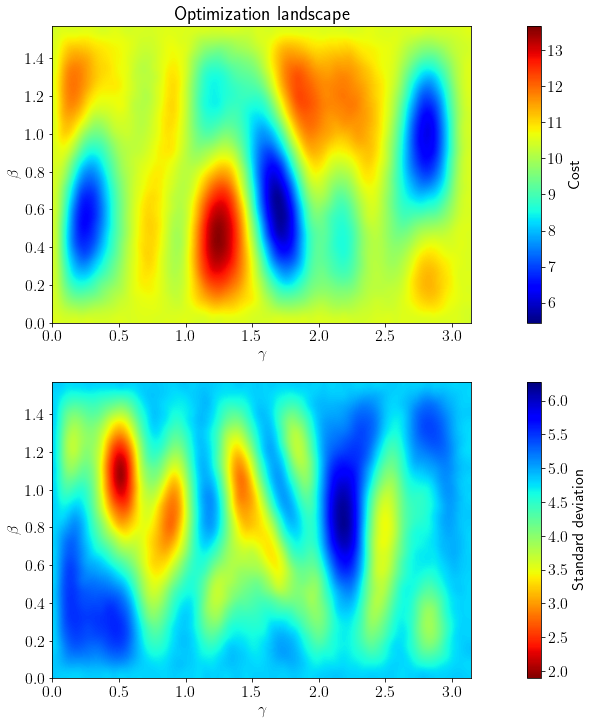

In [15]:
pl.figure(figsize=(10, 12))

pl.subplot(2,1,1)
pl.imshow(np.array(E_landscape).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='bicubic',cmap=cm.jet,aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])
cbar = pl.colorbar(orientation="vertical", pad=0.1)
cbar.set_label('Cost')
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.title('Optimization landscape')

pl.subplot(2,1,2)
pl.imshow(np.array(np.sqrt(v_landscape)).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='bicubic',cmap=cm.jet.reversed(),aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])
cbar = pl.colorbar(orientation="vertical", pad=0.1)
cbar.set_label('Standard deviation')
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')


pl.savefig('E_v_landscape.svg')